In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import gc

In [2]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('../input/quarksgluons/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet') 
first_rows = next(pf.iter_batches(batch_size = 15000, columns=['X_jets', 'y'])) 
df = pa.Table.from_batches([first_rows]).to_pandas() 
del first_rows

In [3]:
X_dataset = np.array(np.array(np.array(df['X_jets'].tolist()).tolist()).tolist())
y_dataset = df['y'].to_numpy()
print(X_dataset.shape, y_dataset.shape)
del df

(15000, 3, 125, 125) (15000,)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, random_state=9)
X_train = np.moveaxis(X_train, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
gc.collect()
del X_dataset, y_dataset

(12000, 125, 125, 3) (12000,)
(3000, 125, 125, 3) (3000,)


In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras import layers
from keras.initializers import glorot_uniform, he_uniform
# kernel_initializer=he_uniform(seed=0)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
    ],
    name="data_augmentation",
)
# data_augmentation.layers[0].adapt(X_train)

2022-03-26 12:24:20.057404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:24:20.144323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:24:20.145216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 12:24:20.146534: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers
from keras import optimizers
from keras import regularizers

num_classes = 1
input_shape = (125, 125, 3)
model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(8, kernel_size=(3,3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
#         layers.Conv2D(16, kernel_size=(3,3), activation="relu"),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(pool_size=(2,2)),
#         layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.005)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)),
    ]
)
model.summary()
# keras.utils.plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 125, 125, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 123, 123, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 123, 123, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 29768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               15241728  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [8]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=4000,
    decay_rate=0.9)
opt_func = keras.optimizers.Adam(learning_rate=lr_schedule)

checkpoint_filepath = 'saved_model'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    save_weights_only=True,
    save_best_only=True)

model.compile(loss='binary_crossentropy',
              optimizer=opt_func,
              metrics=[
                keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=float, threshold=0.5),
                keras.metrics.AUC(name="auc", from_logits=True),
              ],
             )

history = model.fit(X_train,
          y_train,
          epochs=20,
          validation_split=0.2,
          batch_size=32,
          shuffle=True,
          callbacks=[checkpoint_callback])

2022-03-26 12:24:22.449042: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1800000000 exceeds 10% of free system memory.
2022-03-26 12:24:24.261840: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1800000000 exceeds 10% of free system memory.
2022-03-26 12:24:25.581100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-26 12:24:27.334661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


300/300 [==============================] - 12s 17ms/step - loss: 4.4862 - binary_accuracy: 0.6255 - auc: 0.6578 - val_loss: 3.2890 - val_binary_accuracy: 0.6438 - val_auc: 0.7383
Epoch 2/20
300/300 [==============================] - 4s 13ms/step - loss: 2.6028 - binary_accuracy: 0.7688 - auc: 0.8411 - val_loss: 2.2831 - val_binary_accuracy: 0.6762 - val_auc: 0.7290
Epoch 3/20
300/300 [==============================] - 4s 13ms/step - loss: 1.7622 - binary_accuracy: 0.8156 - auc: 0.8910 - val_loss: 1.7854 - val_binary_accuracy: 0.6692 - val_auc: 0.7299
Epoch 4/20
300/300 [==============================] - 4s 13ms/step - loss: 1.2983 - binary_accuracy: 0.8485 - auc: 0.9223 - val_loss: 1.4901 - val_binary_accuracy: 0.6800 - val_auc: 0.7279
Epoch 5/20
300/300 [==============================] - 4s 13ms/step - loss: 1.0462 - binary_accuracy: 0.8684 - auc: 0.9375 - val_loss: 1.3517 - val_binary_accuracy: 0.6850 - val_auc: 0.7228
Epoch 6/20
300/300 [==============================] - 4s 13ms/ste

In [9]:
model.load_weights(checkpoint_filepath)
_, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")
print(f"Test AUC: {auc}")

94/94 [==============================] - 1s 6ms/step - loss: 1.2723 - binary_accuracy: 0.6800 - auc: 0.7314
Test accuracy: 0.6800000071525574
Test AUC: 0.7313769459724426


dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])


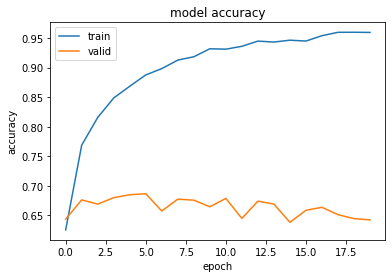

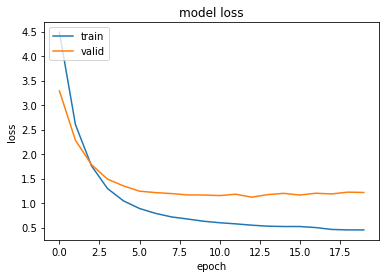

In [10]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()